In [1]:
EXP_NAME = "15_denoising_pretraining"
EXP_NAME

'15_denoising_pretraining'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import monai
from typing import Union, Tuple, Any
from pathlib import Path
Path.ls = lambda p: list(p.iterdir())
from functools import partial
from fastai.data.transforms import get_image_files
import catalyst
from catalyst import dl
import segmentation_models_pytorch as smp
import albumentations as A

# Lookahead imports
from typing import Callable, Dict, Optional
from collections import defaultdict
import torch
from torch.optim import Optimizer

In [3]:
def get_device(verbose: bool = True) -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        if verbose: print("Using the GPU!")
    else:
        device = torch.device("cpu")
        if verbose: print("Using the CPU!")
    return device
    
def load_image_monai(fn: Union[Path, str]) -> np.array:
    image_array = monai.transforms.LoadImage(image_only=True)(str(fn))
    return image_array.__array__().astype(np.uint8)

def plot_image_mask(image: np.array, mask: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if not isinstance(mask, type(np.array([0]))): mask = mask.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    if len(mask.shape) == 3 and mask.shape[0] > 1: mask = mask[0]
    plt.figure(figsize=figsize)
    if image.mean() > 1: plt.imshow(image.astype(np.uint8), interpolation="none")
    else: plt.imshow(image.astype(np.float32), interpolation="none")
    plt.imshow(mask.astype(np.uint8), cmap="jet", alpha=0.5)
    
def plot_image(image: np.array, figsize: Tuple[int, int] = (10, 10)):
    if not isinstance(image, type(np.array([0]))): image = image.detach().cpu().numpy()
    if len(image.shape) == 3 and image.shape[0] == 3: image = image.transpose(1, 2, 0)
    plt.figure(figsize=figsize)
    plt.imshow(image, interpolation="none")

def fn2image(fn: Union[Path, str]) -> np.array:
    return load_image_monai(fn)

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2image(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2image(fn)

def fn2id(fn: Union[Path, str]) -> str:
    return str(fn).split("/")[-1].split(".")[0]

def id2fn(fid: str) -> Path:
    return COMBINED_DF[COMBINED_DF.id == int(fid)]["fnames"].values[0]

def id2rle(fid: str) -> str:
    rle = TRAIN_DF[TRAIN_DF.id==int(fid)]["rle"].values[0]
    return rle

def fn2rle(fn: Union[Path, str]) -> str:
    fid = fn2id(fn)
    return id2rle(fid)

def id2organ(fid: str) -> str:
    organ = TRAIN_DF[TRAIN_DF.id==int(fid)]["organ"].values[0]
    return organ

def id2shape(fid: str) -> Tuple[int, int]:
    width = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_width"].values[0]
    height = COMBINED_DF[COMBINED_DF.id==int(fid)]["img_height"].values[0]
    return width, height

def fn2shape(fn: Union[Path, str]) -> Tuple[int, int]:
    fid = fn2id(fn)
    return id2shape(fid)

def load_mask(fn: Union[Path, str]) -> np.array:
    shape = fn2shape(fn)
    rle = fn2rle(fn)
    return rle_decode(rle, shape)

def fn2mask(fn: Union[Path, str]) -> np.array:
    return load_mask(fn)

def id2mask(fid: str) -> np.array:
    fn = id2fn(fid)
    return fn2mask(fn)

def save_df(df:Dict[str, Any], df_file:str, replace:bool=False):
    if replace: return pd.DataFrame(df).to_csv(df_file, index=False)
    try: 
        d = pd.read_csv(df_file)
        d = pd.concat([d, pd.DataFrame(df)])
    except FileNotFoundError: 
        d = pd.DataFrame(df)
    d.to_csv(df_file, index=False)

def load_df(df_file: str) -> pd.DataFrame:
    try:  df = pd.read_csv(df_file)
    except FileNotFoundError: df = None
    return df

def calc_metric(
        y_hat:torch.Tensor,
        y:torch.Tensor,
        metric_func:callable,
        process_logits:callable=monai.transforms.Compose([
                monai.transforms.EnsureType(), 
                monai.transforms.Activations(softmax=True),
                monai.transforms.AsDiscrete(argmax=True)
            ])) -> float:
    y_hat = [process_logits(i) for i in monai.data.decollate_batch(y_hat)]
    y = [i for i in monai.data.decollate_batch(y)]
    metric = metric_func(y_hat, y)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

In [4]:
# From: https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return np.reshape(img, shape)
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [5]:
def split_df_train_test(df, colname, seed=9210, test_pct=0.2):
    df = df.copy()
    np.random.seed(seed)
    indices = np.arange(len(df))
    np.random.shuffle(indices)
    test_ids = df.id.values[indices[:int(test_pct*len(indices))]]
    df[colname] = df.id.apply(lambda fid: fid in test_ids)
    return df

In [6]:
class Lookahead(Optimizer):
    """Implements Lookahead algorithm.

    It has been proposed in `Lookahead Optimizer: k steps forward,
    1 step back`_.

    Main origins of inspiration:
        https://github.com/alphadl/lookahead.pytorch (MIT License)

    .. _`Lookahead Optimizer\: k steps forward, 1 step back`:
        https://arxiv.org/abs/1907.08610
    """

    def __init__(self, optimizer: Optimizer, k: int = 5, alpha: float = 0.5):
        """@TODO: Docs. Contribution is welcome."""
        self.optimizer = optimizer
        self.k = k
        self.alpha = alpha
        self.param_groups = self.optimizer.param_groups
        self.defaults = self.optimizer.defaults
        self.state = defaultdict(dict)
        self.fast_state = self.optimizer.state
        for group in self.param_groups:
            group["counter"] = 0


    def update(self, group):
        """@TODO: Docs. Contribution is welcome."""
        for fast in group["params"]:
            param_state = self.state[fast]
            if "slow_param" not in param_state:
                param_state["slow_param"] = torch.zeros_like(fast.data)
                param_state["slow_param"].copy_(fast.data)
            slow = param_state["slow_param"]
            slow += (fast.data - slow) * self.alpha
            fast.data.copy_(slow)


    def update_lookahead(self):
        """@TODO: Docs. Contribution is welcome."""
        for group in self.param_groups:
            self.update(group)


    def step(self, closure: Optional[Callable] = None):
        """Makes optimizer step.

        Args:
            closure (callable, optional): A closure that reevaluates
                the model and returns the loss.
        """
        loss = self.optimizer.step(closure)
        for group in self.param_groups:
            if group["counter"] == 0:
                self.update(group)
            group["counter"] += 1
            if group["counter"] >= self.k:
                group["counter"] = 0
        return loss


    def state_dict(self):
        """@TODO: Docs. Contribution is welcome."""
        fast_state_dict = self.optimizer.state_dict()
        slow_state = {
            (id(k) if isinstance(k, torch.Tensor) else k): v
            for k, v in self.state.items()
        }
        fast_state = fast_state_dict["state"]
        param_groups = fast_state_dict["param_groups"]
        return {
            "fast_state": fast_state,
            "slow_state": slow_state,
            "param_groups": param_groups,
        }


    def load_state_dict(self, state_dict):
        """@TODO: Docs. Contribution is welcome."""
        slow_state_dict = {
            "state": state_dict["slow_state"],
            "param_groups": state_dict["param_groups"],
        }
        fast_state_dict = {
            "state": state_dict["fast_state"],
            "param_groups": state_dict["param_groups"],
        }
        super(Lookahead, self).load_state_dict(slow_state_dict)
        self.optimizer.load_state_dict(fast_state_dict)
        self.fast_state = self.optimizer.state


    def add_param_group(self, param_group):
        """@TODO: Docs. Contribution is welcome."""
        param_group["counter"] = 0
        self.optimizer.add_param_group(param_group)


    @classmethod
    def get_from_params(
        cls, params: Dict, base_optimizer_params: Dict = None, **kwargs,
    ) -> "Lookahead":
        """@TODO: Docs. Contribution is welcome."""
        from catalyst.dl.registry import OPTIMIZERS

        base_optimizer = OPTIMIZERS.get_from_params(
            params=params, **base_optimizer_params
        )
        optimizer = cls(optimizer=base_optimizer, **kwargs)
        return optimizer

In [7]:
TRAIN_DF = pd.read_csv("../data/train.csv")
TEST_DF = pd.read_csv("../data/test.csv")

TRAIN_IMAGES = get_image_files("../data/train_images")
TEST_IMAGES = get_image_files("../data/test_images")
ALL_IMAGES = [*TRAIN_IMAGES, *TEST_IMAGES]

In [8]:
KEYS = ["image", "label"]
IMAGE = "image"
LABEL = "label"
DEVICE = get_device()
TRANSFORM_PROB = 0.5
CROP_SIZE = (2700, 2700)
IMAGE_SIZE = (512, 512)
MIN_CROP_SIZE = (160, 160) # Smallest imagesize in hidden testset (https://www.kaggle.com/competitions/hubmap-organ-segmentation/data)
EPOCHS = 200
ACCUM_STEPS = 4
BATCH_SIZE = 8
LR_BS = 4.6875e-05
LR = LR_BS * BATCH_SIZE * ACCUM_STEPS
EARLY_STOP_PATIENCE = 100
ENCODER = "efficientnet-b3"
GAUSS_STD = 0.8 * IMAGE_SIZE[0] / 1000 

LOG_DIR = Path("../logs")/EXP_NAME
LOG_DIR.mkdir(exist_ok=True)

Using the GPU!


In [9]:
def add_fnames(df:pd.DataFrame)->pd.DataFrame:
    df = df.copy()
    fnames = []
    for fid in df.id.values: fnames.append([fname for fname in ALL_IMAGES if str(fid) in fname.stem][0])
    df["fnames"] = fnames
    return df

def test_model(
        model:torch.nn.Module, 
        dl:monai.data.DataLoader, 
        metric_func:callable, 
        threshold:float=0.5) -> float:
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for data in tqdm(iter(dl), total=len(dl)):
            X, y = data[IMAGE].to(DEVICE), data[LABEL]
            y_hat = model(X).detach().cpu()
            preds = [*preds, *[logit_process(i) for i in y_hat]]
            trues = [*trues, *[i for i in monai.data.decollate_batch(y)]]
    metric_func(preds, trues)
    metric = metric_func.aggregate().item()
    metric_func.reset()
    return metric

def load_weights(model:torch.nn.Module, weights_path:Union[str,Path], device:torch.device=DEVICE)->torch.nn.Module:
    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)
    return model.to(device)

def make3D(t: np.array) -> np.array:
    t = np.expand_dims(t, axis=2)
    t = np.concatenate((t,t,t), axis=2)
    return t

def plot_results(model, dl, threshold=0.5, figsize=10):
    logit_process = monai.transforms.Compose([
        monai.transforms.EnsureType(), 
        monai.transforms.Activations(softmax=True),
        monai.transforms.AsDiscrete(threshold=threshold)
    ])
    max_size = 2**16
    model = model.to(DEVICE)
    model.eval()
    ims, preds, labels = [], [], []
    with torch.no_grad():
        for item in tqdm(iter(dl), total=len(dl)):
            X, y = item[IMAGE].to(DEVICE), item[LABEL].cpu()
            y_hat = model(X).detach().cpu()
            ims = [*ims, *[im.numpy() for im in X.detach().cpu()]]
            preds = [*preds, *[logit_process(pred).numpy() for pred in y_hat]]
            labels = [*labels, *[lbl.numpy() for lbl in y]]
    
    vs = []
    for i, b in enumerate(range(len(preds))):
        if (i+1) * preds[0].shape[1] * figsize > max_size:
            print("Dataset to big, only displaying a portion of it!")
            break
        
        im = np.einsum("cwh->whc", ims[b])
        pred = make3D(preds[b][1])
        label = make3D(labels[b][1])
        vs.append(np.hstack((im, pred, label)))
    

    plt.figure(figsize=(figsize, figsize*len(vs)))
    plt.title("Input / Prediction / Target")
    plt.imshow(np.vstack(vs))

def one_batch(
        dl:monai.data.DataLoader, 
        b_idx:int=0, 
        unpacked:bool=False) -> Union[Dict[str, Any], Tuple[torch.Tensor, torch.Tensor]]:
    assert b_idx < len(dl), f"DataLoader only has {len(dl)} batches..."
    for i, items in enumerate(iter(dl)):
        if i == b_idx: 
            if unpacked:
                X, y = items[IMAGE].to(DEVICE), items[LABEL].to(DEVICE)
                return X, y
            return items
def batch2numpy(batch:Dict[str,torch.Tensor])->Tuple[np.array]:
    return batch[IMAGE].detach().cpu().numpy(), batch[LABEL].detach().cpu().numpy()
def plot_batch(batch:Dict[str, torch.Tensor], figsize:int=10):
    X, y = batch2numpy(batch)
    vstacks = []
    for b in range(X.shape[0]):
        im = X[b].transpose(1, 2, 0)
        msk = make3D(y[b, 1])
        vstacks.append(np.hstack((im,msk)))
    patchwork = np.vstack(vstacks)
    plt.figure(figsize=(figsize, figsize*X.shape[0]))
    plt.imshow(patchwork)

In [10]:
TRAIN_DF = add_fnames(TRAIN_DF)
TEST_DF = add_fnames(TEST_DF)
COMBINED_DF = pd.concat([TRAIN_DF, TEST_DF])
COMBINED_DF.drop(columns="rle").head(2)

id     organ data_source  img_height  img_width  pixel_size  \
0  10044  prostate         HPA        3000       3000         0.4   
1  10274  prostate         HPA        3000       3000         0.4   

   tissue_thickness   age   sex                           fnames  
0                 4  37.0  Male  ../data/train_images/10044.tiff  
1                 4  76.0  Male  ../data/train_images/10274.tiff

In [11]:
def add_gaussian_noise(arr):
    noisy_arr = arr + torch.randn(*arr.shape)*GAUSS_STD
    return noisy_arr.to(arr.dtype)

def get_noisy_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        # Load the same image in 'image' and 'label' 
        monai.transforms.Lambdad(KEYS, fn2image),
        monai.transforms.TransposeD(KEYS, (2, 0, 1)),
        monai.transforms.ScaleIntensityD(KEYS),
        #monai.transforms.CenterSpatialCropd(KEYS,roi_size=CROP_SIZE),

        #monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=CROP_SIZE),
        monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE),
        #monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=IMAGE_SIZE),

        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "bilinear")),
        monai.transforms.RandRotated(KEYS, range_x=np.pi, prob=1, padding_mode="reflection"),
        monai.transforms.Lambdad(IMAGE, add_gaussian_noise),
        monai.transforms.EnsureTypeD(KEYS)
    ])

In [12]:
def plot_image_noisy_image(noise_im, im, figsize=10):
    noise_im, im = noise_im.numpy(), im.numpy()
    noise_im, im = noise_im.transpose(1, 2, 0), im.transpose(1, 2, 0)
    plt.figure(figsize=(figsize, figsize))
    plt.imshow(np.hstack((noise_im, im)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


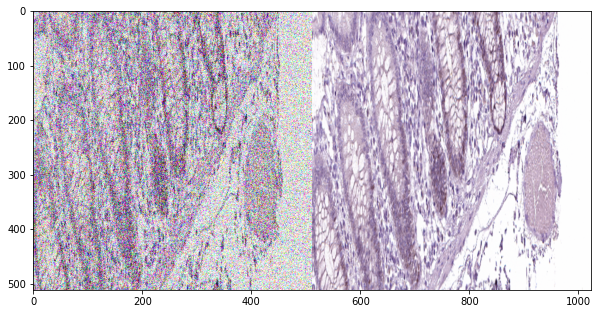

In [13]:
fn = np.random.choice(COMBINED_DF.fnames.values)
d = {IMAGE:fn,LABEL:fn}
d = get_noisy_transforms()(d)
plot_image_noisy_image(d[IMAGE], d[LABEL])

In [14]:
x = torch.rand([16, 1, 16, 16])
y = x * 0.75
data_range = x.max().unsqueeze(0)
monai.losses.ssim_loss.SSIMLoss()(x,y,data_range)

tensor(0.0781)

In [15]:
class MAELOSS(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l = torch.nn.L1Loss()
        self.s = torch.sigmoid
    def forward(self, y_hat, y): return self.l(self.s(y_hat), y)
y_hat, y = torch.rand(2, 3, 256, 256), torch.rand(2, 3, 256, 256)
MAELOSS()(y_hat, y)

tensor(0.2692)

In [16]:
class SSIMLossWrapper(torch.nn.Module):
    def __init__(self, sigmoid=True, include_background=True):
        super().__init__()
        self.l = monai.losses.ssim_loss.SSIMLoss(spatial_dims=2)
        self.s = torch.sigmoid
        self.apply_sigmoid = sigmoid
        self.include_background = include_background
    def forward(self, y_hat, y):
        loss = 0
        for channel in range(y_hat.shape[1]):
            if not self.include_background and channel == 0: continue
            if self.apply_sigmoid: p = self.s(y_hat[:,channel].unsqueeze(1))
            else: p = y_hat[:,channel].unsqueeze(1)
            t = y[:,channel].unsqueeze(1)
            dr = p.max().unsqueeze(0) - p.min().unsqueeze(0)
            if self.include_background: loss += self.l(p, t, dr) / y_hat.shape[1]
            else: loss += self.l(p, t, dr) / (y_hat.shape[1] - 1)
        return loss
SSIMLossWrapper(sigmoid=False)(y_hat, y), SSIMLossWrapper(sigmoid=True)(y_hat, y), SSIMLossWrapper(sigmoid=False, include_background=False)(y_hat, y),
#SSIMLossWrapper(sigmoid=False)(torch.ones([1,1,10,10])/2, torch.ones([1,1,10,10])/2)

(tensor(0.9962), tensor(1.0001), tensor(0.9966))

In [17]:
class CombinedLoss(torch.nn.Module):
    def __init__(self, sigmoid=True):
        super().__init__()
        self.ssim = SSIMLossWrapper(sigmoid=sigmoid)
        self.mae = MAELOSS()
    def forward(self, y_hat, y): 
        return self.ssim(y_hat, y) + self.mae(y_hat, y)
CombinedLoss()(y_hat, y)

tensor(1.2693)

In [18]:
class SSIMGDICEFOCAL(torch.nn.Module):
    def __init__(self, sigmoid=True, include_background=True):
        super().__init__()
        self.ssim = SSIMLossWrapper(sigmoid=sigmoid, include_background=include_background)
        self.gdice_focal = monai.losses.GeneralizedDiceFocalLoss(softmax=True)
    def forward(self, y_hat, y):
        return self.gdice_focal(y_hat, y) + self.ssim(y_hat, y) 
SSIMGDICEFOCAL()(y_hat, y), SSIMGDICEFOCAL(sigmoid=False, include_background=True)(y_hat, y), SSIMGDICEFOCAL(sigmoid=True, include_background=False)(y_hat, y)

(tensor(1.7654), tensor(1.7615), tensor(1.7656))

In [19]:
def alb_wrapper(arr, f):
    datatype = arr.dtype
    arr = torch.einsum("cwh->whc", arr) * 255.
    arr = f(image=arr.numpy().astype(np.uint8))["image"]
    arr = torch.Tensor(arr).to(datatype) / 255.
    return torch.einsum("whc->cwh", arr)
huesat = partial(alb_wrapper, f=A.HueSaturationValue(
    p=1, 
    hue_shift_limit=80,
    sat_shift_limit=80, 
    val_shift_limit=80, 
    always_apply=True))

In [20]:
def get_load_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
    ])

def get_train_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        *get_load_transforms().transforms,

        monai.transforms.CenterSpatialCropd(KEYS,roi_size=CROP_SIZE),
        
        monai.transforms.RandSpatialCropd(KEYS, roi_size=MIN_CROP_SIZE, max_roi_size=CROP_SIZE),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.Lambdad((IMAGE,), huesat),
        
        monai.transforms.RandAdjustContrastd((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandGaussianNoised((IMAGE,), prob=TRANSFORM_PROB),
        monai.transforms.RandCoarseShuffled((IMAGE,), 
            holes=2, 
            max_holes=15, 
            spatial_size=(int(IMAGE_SIZE[0]*0.01), int(IMAGE_SIZE[1]*0.01)), 
            max_spatial_size=(int(IMAGE_SIZE[0]*0.1), int(IMAGE_SIZE[1]*0.1)),  
            prob=TRANSFORM_PROB),

        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_valid_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.RandRotated(KEYS, range_x=3.14159, prob=1, padding_mode="reflection"),
        monai.transforms.AsDiscreteD((LABEL,), threshold=0.5),
        monai.transforms.EnsureTypeD(KEYS)
])

def get_test_transforms() -> monai.transforms.Compose:
    return monai.transforms.Compose([
        monai.transforms.Lambdad((IMAGE,), id2image),
        monai.transforms.TransposeD((IMAGE,), (2, 0, 1)),
        monai.transforms.Lambdad((LABEL,), id2mask),
        monai.transforms.AddChanneld((LABEL,)),
        monai.transforms.AsDiscreted((LABEL,), to_onehot=2),
        monai.transforms.ScaleIntensityD((IMAGE,)),
        monai.transforms.ResizeD(KEYS, spatial_size=IMAGE_SIZE, mode=("bilinear", "nearest-exact")),
        monai.transforms.EnsureTypeD(KEYS)
])

In [21]:
organ = "spleen"

In [22]:
# get additional datafiles for this organ
ADDITIONAL_IMAGES = get_image_files("../data/additional_images/images")
ADDITIONAL_IMAGES = [fn for fn in ADDITIONAL_IMAGES if organ in fn.stem]
add_idx = list(range(len(ADDITIONAL_IMAGES)))
np.random.shuffle(add_idx)
cutoff = int(0.8 * len(add_idx))
ADD_TRAIN = ADDITIONAL_IMAGES[:cutoff]
ADD_VALID = ADDITIONAL_IMAGES[cutoff:]
data_dicts = {
    "train": {i: {IMAGE: fn, LABEL: fn} for i, fn in enumerate(ADD_TRAIN)},
    "valid": {i: {IMAGE: fn, LABEL: fn} for i, fn in enumerate(ADD_VALID)}
}
train_ds = monai.data.PersistentDataset(data_dicts["train"], transform=get_noisy_transforms(), cache_dir="../data/cache_dir/additional_images")
valid_ds = monai.data.PersistentDataset(data_dicts["valid"], transform=get_noisy_transforms(), cache_dir="../data/cache_dir/additional_images")
train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
loaders = {"train": train_dl, "valid": valid_dl}
model = smp.Unet(
    encoder_name="efficientnet-b3",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3,  
)
#model = monai.networks.nets.SwinUNETR(
#    IMAGE_SIZE[0], 
#    3, 
#    3, 
#    spatial_dims=2,
#    depths=(2, 2, 2, 2), 
#    num_heads=(3, 6, 12, 24), 
#    feature_size=24, 
#    drop_rate=0.0, 
#    attn_drop_rate=0.0, 
#    dropout_path_rate=0.0
#)
# remove this line:
#model.load_state_dict(torch.load("/home/favi/work/kaggle/hubmap_reboot/logs/denoising_pretraining/lung_denoise/checkpoints/model.0126.pth"))
criterion = SSIMLossWrapper()
optimizer = Lookahead(torch.optim.RAdam([*model.decoder.parameters(), *model.segmentation_head.parameters()], lr=LR))
#optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)
callbacks = [
    catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=ACCUM_STEPS),
    catalyst.dl.EarlyStoppingCallback(
        patience=EARLY_STOP_PATIENCE, 
        loader_key="valid", 
        metric_key="loss",
        min_delta=1e-3,
        minimize=True)
]

runner = catalyst.dl.SupervisedRunner(
    input_key=IMAGE, 
    output_key="logits", 
    target_key=LABEL, 
    loss_key="loss"
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=5,
    callbacks=callbacks,
    logdir=LOG_DIR/f"{organ}_denoise",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=True,
    timeit=False,
    load_best_on_end=False
)

1/5 * Epoch (train):   0%|          | 0/753 [00:00<?, ?it/s]

train (1/5) loss: 0.629017626305184 | loss/mean: 0.629017626305184 | loss/std: 0.2152752754899143 | lr: 0.0015 | momentum: 0.9


1/5 * Epoch (valid):   0%|          | 0/189 [00:00<?, ?it/s]

valid (1/5) loss: 0.4078944998670859 | loss/mean: 0.4078944998670859 | loss/std: 0.030509144045335744 | lr: 0.0015 | momentum: 0.9
* Epoch (1/5) lr: 0.0013567627457812105 | momentum: 0.9


2/5 * Epoch (train):   0%|          | 0/753 [00:00<?, ?it/s]

train (2/5) loss: 0.3849539107297996 | loss/mean: 0.3849539107297996 | loss/std: 0.030217445795511458 | lr: 0.0013567627457812105 | momentum: 0.9


2/5 * Epoch (valid):   0%|          | 0/189 [00:00<?, ?it/s]

valid (2/5) loss: 0.36680654874677526 | loss/mean: 0.36680654874677526 | loss/std: 0.030986189257825883 | lr: 0.0013567627457812105 | momentum: 0.9
* Epoch (2/5) lr: 0.0009817627457812106 | momentum: 0.9


3/5 * Epoch (train):   0%|          | 0/753 [00:00<?, ?it/s]

train (3/5) loss: 0.3666362707437588 | loss/mean: 0.3666362707437588 | loss/std: 0.02843939629478508 | lr: 0.0009817627457812106 | momentum: 0.9


3/5 * Epoch (valid):   0%|          | 0/189 [00:00<?, ?it/s]

valid (3/5) loss: 0.3578857490186831 | loss/mean: 0.3578857490186831 | loss/std: 0.03051399493107815 | lr: 0.0009817627457812106 | momentum: 0.9
* Epoch (3/5) lr: 0.0005182372542187895 | momentum: 0.9


4/5 * Epoch (train):   0%|          | 0/753 [00:00<?, ?it/s]

train (4/5) loss: 0.35876927017215693 | loss/mean: 0.35876927017215693 | loss/std: 0.02934806766018534 | lr: 0.0005182372542187895 | momentum: 0.9


4/5 * Epoch (valid):   0%|          | 0/189 [00:00<?, ?it/s]

valid (4/5) loss: 0.35338169455053303 | loss/mean: 0.35338169455053303 | loss/std: 0.02974936371618425 | lr: 0.0005182372542187895 | momentum: 0.9
* Epoch (4/5) lr: 0.0001432372542187895 | momentum: 0.9


5/5 * Epoch (train):   0%|          | 0/753 [00:00<?, ?it/s]

train (5/5) loss: 0.3545856808286267 | loss/mean: 0.3545856808286267 | loss/std: 0.028269810798934588 | lr: 0.0001432372542187895 | momentum: 0.9


5/5 * Epoch (valid):   0%|          | 0/189 [00:00<?, ?it/s]

valid (5/5) loss: 0.34675481151616255 | loss/mean: 0.34675481151616255 | loss/std: 0.028756303193861143 | lr: 0.0001432372542187895 | momentum: 0.9
* Epoch (5/5) lr: 0.0015 | momentum: 0.9
Top models:
../logs/15_denoising_pretraining/spleen_denoise/checkpoints/model.0005.pth	0.3468


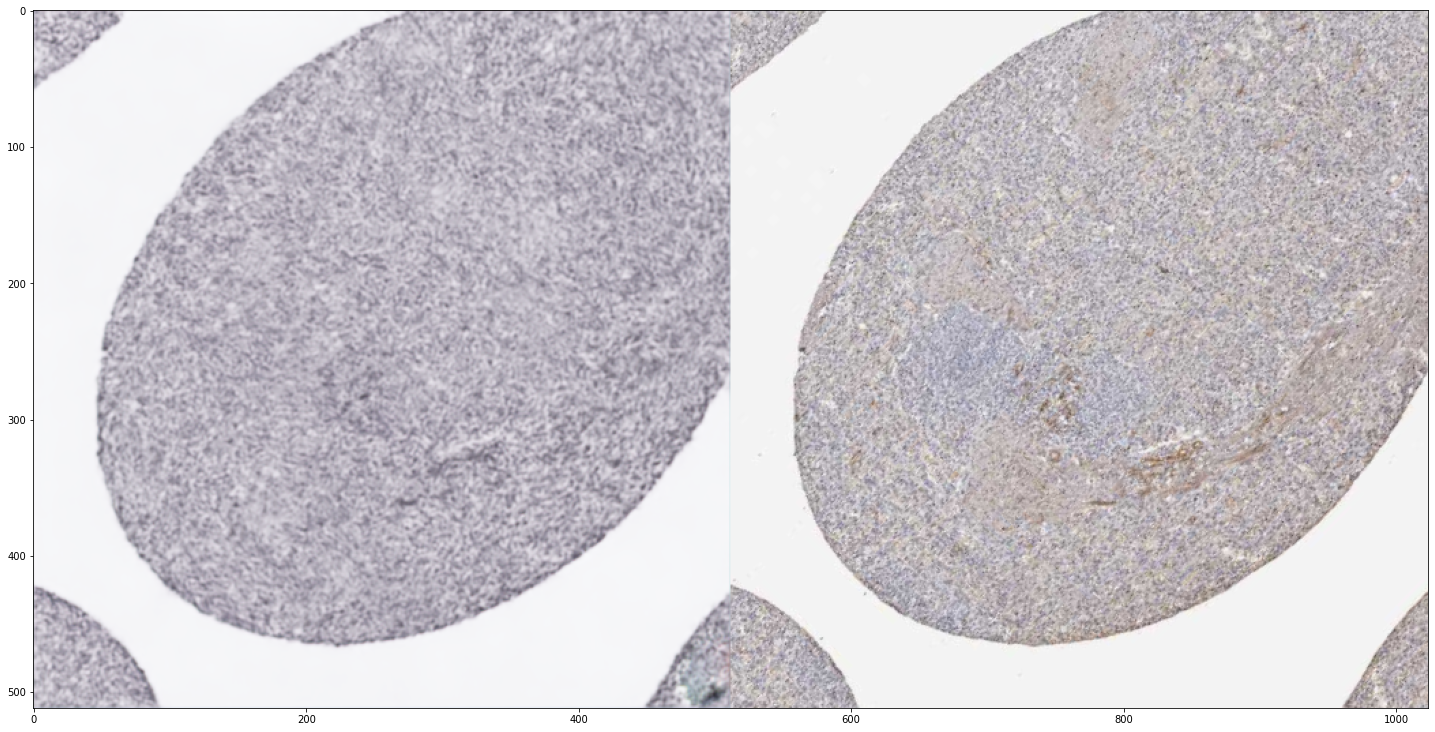

In [23]:
d = next(iter(valid_dl))
X, y = d[IMAGE].to(DEVICE), d[LABEL].cpu()
y_hat = torch.sigmoid(model(X)).detach().cpu()
i = 0
plot_image_noisy_image(y_hat[i], y[i], figsize=25)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


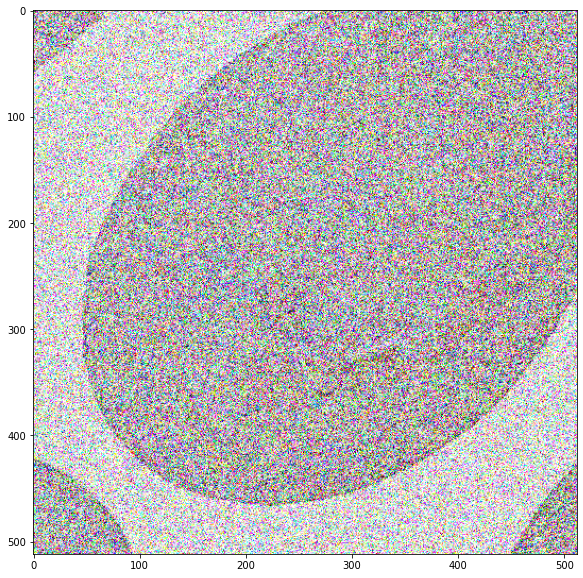

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(X[i].detach().cpu().numpy().transpose(1, 2, 0))

In [25]:
organ = "spleen"

In [26]:
organ_train_test_df = split_df_train_test(TRAIN_DF[TRAIN_DF.organ==organ],"is_test", test_pct=0.1)
organ_testset_df = organ_train_test_df[organ_train_test_df.is_test].copy()
organ_train_valid_df = organ_train_test_df[~organ_train_test_df.is_test].copy()
organ_train_valid_df = split_df_train_test(organ_train_valid_df, "is_valid", seed=92)
assert len(organ_testset_df.organ.unique()) == 1
assert len(organ_train_valid_df.organ.unique()) == 1
del organ_train_test_df

train_ids = organ_train_valid_df[~organ_train_valid_df.is_valid].id.values
valid_ids = organ_train_valid_df[organ_train_valid_df.is_valid].id.values
test_ids = organ_testset_df.id.values
assert len(set(train_ids).intersection(set(valid_ids))) == 0
assert len(set(train_ids).intersection(set(test_ids))) == 0
assert len(set(valid_ids).intersection(set(test_ids))) == 0

data_dicts = {
    "train": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(train_ids)},
    "valid": {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(valid_ids)},
    "test":  {i: {IMAGE: fid, LABEL: fid} for i, fid in enumerate(test_ids)}
}

train_ds = monai.data.CacheDataset(data_dicts["train"], transform=get_train_transforms())
valid_ds = monai.data.CacheDataset(data_dicts["valid"], transform=get_valid_transforms())
test_ds  = monai.data.CacheDataset(data_dicts["test"],  transform=get_test_transforms())

train_dl = monai.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = monai.data.DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl  = monai.data.DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

loaders = {"train": train_dl, "valid": valid_dl}

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]


In [27]:
# transfer learn
model = smp.Unet(
    encoder_name="efficientnet-b3",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3,  
)
model.load_state_dict(torch.load("../logs/15_denoising_pretraining/spleen_denoise/checkpoints/model.0005.pth"))
model.segmentation_head = torch.nn.Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
#model = monai.networks.nets.SwinUNETR(
#    IMAGE_SIZE[0], 
#    3, 
#    3, 
#    spatial_dims=2,
#    depths=(2, 2, 2, 2), 
#    num_heads=(3, 6, 12, 24), 
#    feature_size=24, 
#    drop_rate=0.0, 
#    attn_drop_rate=0.0, 
#    dropout_path_rate=0.0
#)
# remove this line:
#model.load_state_dict(torch.load("../logs/15_denoising_pretraining/colon_denoise/checkpoints/model.0005.pth"))
#model.out.conv.conv = torch.nn.Conv2d(24, 2, kernel_size=(1, 1), stride=(1, 1))
model = model.to(DEVICE)

criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)#SSIMGDICEFOCAL(include_background=False)#SSIMGDICEFOCAL(include_background=False)#monai.losses.GeneralizedDiceFocalLoss(softmax=True)
#optimizer = Lookahead(torch.optim.RAdam(model.out.parameters(), lr=LR/100))
optimizer = Lookahead(torch.optim.RAdam(model.segmentation_head.parameters(), lr=LR/100))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

dice_func = partial(
    calc_metric, 
    metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

callbacks = [
    catalyst.dl.FunctionalMetricCallback(
    input_key="logits",
    target_key=LABEL,
    metric_fn=dice_func,
    metric_key="dice"
    ),
    catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=ACCUM_STEPS),
    catalyst.dl.EarlyStoppingCallback(
        patience=EARLY_STOP_PATIENCE, 
        loader_key="valid", 
        metric_key="loss",
        min_delta=1e-3,
        minimize=True)
]

runner = catalyst.dl.SupervisedRunner(
    input_key=IMAGE, 
    output_key="logits", 
    target_key=LABEL, 
    loss_key="loss"
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=5,
    callbacks=callbacks,
    logdir=LOG_DIR/f"{organ}_transfered",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=False,
    timeit=False,
    load_best_on_end=True
)

dice_metric = monai.metrics.DiceMetric(
    include_background=False, 
    reduction="mean")

train_dice = test_model(model, train_dl, metric_func=dice_metric)
valid_dice = test_model(model, valid_dl, metric_func=dice_metric)
test_dice = test_model(model, test_dl, metric_func=dice_metric)

train_dice, valid_dice, test_dice

train (1/5) dice: 0.07340352867658322 | dice/mean: 0.07340352867658322 | dice/std: 0.025585172152154237 | loss: 0.8015378652474819 | loss/mean: 0.8015378652474819 | loss/std: 0.11936262856238714 | lr: 1.5e-05 | momentum: 0.9
valid (1/5) dice: 0.15946023580100802 | dice/mean: 0.15946023580100802 | dice/std: 0.03820881495873133 | loss: 9.571207576327854 | loss/mean: 9.571207576327854 | loss/std: 0.3349758783976236 | lr: 1.5e-05 | momentum: 0.9
* Epoch (1/5) lr: 1.3567627457812107e-05 | momentum: 0.9
train (2/5) dice: 0.09534478225769141 | dice/mean: 0.09534478225769141 | dice/std: 0.02252609054115768 | loss: 0.70026706579404 | loss/mean: 0.70026706579404 | loss/std: 0.05908365946060614 | lr: 1.3567627457812107e-05 | momentum: 0.9
valid (2/5) dice: 0.1496215123269293 | dice/mean: 0.1496215123269293 | dice/std: 0.03701677670081457 | loss: 4.054152170817058 | loss/mean: 4.054152170817058 | loss/std: 4.525547981262207 | lr: 1.3567627457812107e-05 | momentum: 0.9
* Epoch (2/5) lr: 9.817627457

100%|██████████| 1/1 [00:00<00:00, 20.04it/s]


(0.08385904133319855, 0.06510145217180252, 0.06181994080543518)

In [ ]:
#DROPRATE = 0.6

In [29]:
# finetune
#model = monai.networks.nets.SwinUNETR(
#    IMAGE_SIZE[0], 
#    3, 
#    2, 
#    spatial_dims=2,
#    depths=(2, 2, 2, 2), 
#    num_heads=(3, 6, 12, 24), 
#    feature_size=24, 
#    drop_rate=DROPRATE, 
#    attn_drop_rate=DROPRATE, 
#    dropout_path_rate=DROPRATE
#)
model = smp.Unet(
    encoder_name="efficientnet-b3",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3,  
)
model.segmentation_head = torch.nn.Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# remove this line:
model.load_state_dict(torch.load("../logs/15_denoising_pretraining/spleen_transfered/checkpoints/model.0004.pth"))
model = model.to(DEVICE)

criterion = monai.losses.GeneralizedDiceFocalLoss(softmax=True)#SSIMGDICEFOCAL(include_background=False)#monai.losses.GeneralizedDiceFocalLoss(softmax=True)
optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

dice_func = partial(
    calc_metric, 
    metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

callbacks = [
    catalyst.dl.FunctionalMetricCallback(
    input_key="logits",
    target_key=LABEL,
    metric_fn=dice_func,
    metric_key="dice"
    ),
    catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=ACCUM_STEPS),
    catalyst.dl.EarlyStoppingCallback(
        patience=EARLY_STOP_PATIENCE, 
        loader_key="valid", 
        metric_key="loss",
        min_delta=1e-3,
        minimize=True)
]

runner = catalyst.dl.SupervisedRunner(
    input_key=IMAGE, 
    output_key="logits", 
    target_key=LABEL, 
    loss_key="loss"
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=200,
    callbacks=callbacks,
    logdir=LOG_DIR/f"{organ}_finetuned",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=False,
    timeit=False,
    load_best_on_end=True
)

dice_metric = monai.metrics.DiceMetric(
    include_background=False, 
    reduction="mean")

train_dice = test_model(model, train_dl, metric_func=dice_metric)
valid_dice = test_model(model, valid_dl, metric_func=dice_metric)
test_dice = test_model(model, test_dl, metric_func=dice_metric)

train_dice, valid_dice, test_dice

train (1/200) dice: 0.0460964703024962 | dice/mean: 0.0460964703024962 | dice/std: 0.016801384935069368 | loss: 0.7953138030492343 | loss/mean: 0.7953138030492343 | loss/std: 0.07603393156042298 | lr: 0.0015 | momentum: 0.9
valid (1/200) dice: 0.0507361458407508 | dice/mean: 0.0507361458407508 | dice/std: 0.06326619659860928 | loss: 0.8017561965518527 | loss/mean: 0.8017561965518527 | loss/std: 0.08263186613718669 | lr: 0.0015 | momentum: 0.9
* Epoch (1/200) lr: 0.0013567627457812105 | momentum: 0.9
train (2/200) dice: 0.07441557485323685 | dice/mean: 0.07441557485323685 | dice/std: 0.033524874635608215 | loss: 0.8180473890060034 | loss/mean: 0.8180473890060034 | loss/std: 0.07932781082200657 | lr: 0.0013567627457812105 | momentum: 0.9
valid (2/200) dice: 0.02301598671409819 | dice/mean: 0.02301598671409819 | dice/std: 0.044447255941728755 | loss: 0.8469312455919054 | loss/mean: 0.8469312455919054 | loss/std: 0.05985840161641439 | lr: 0.0013567627457812105 | momentum: 0.9
* Epoch (2/20

100%|██████████| 1/1 [00:00<00:00, 23.59it/s]


(0.6105373501777649, 0.5539929866790771, 0.6696673631668091)

In [ ]:
model = smp.Unet(
    encoder_name="efficientnet-b3",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3,  
)
model.segmentation_head = torch.nn.Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
# remove this line:
model.load_state_dict(torch.load("../logs/15_denoising_pretraining/lung_finetuned/checkpoints/model.0099.pth"))
model = model.to(DEVICE)

In [ ]:
# add train
model = monai.networks.nets.SwinUNETR(
    IMAGE_SIZE[0], 
    3, 
    2, 
    spatial_dims=2,
    depths=(2, 2, 2, 2), 
    num_heads=(3, 6, 12, 24), 
    feature_size=24, 
    drop_rate=DROPRATE, 
    attn_drop_rate=DROPRATE, 
    dropout_path_rate=DROPRATE
)
# remove this line:
model.load_state_dict(torch.load("../logs/15_denoising_pretraining/prostate_finetuned/checkpoints/model.0197.pth"))
model = model.to(DEVICE)

# transfer learn
criterion = SSIMGDICEFOCAL(include_background=False)#monai.losses.GeneralizedDiceFocalLoss(softmax=True)
optimizer = Lookahead(torch.optim.RAdam(model.parameters(), lr=LR))
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 5)

dice_func = partial(
    calc_metric, 
    metric_func=monai.metrics.DiceMetric(include_background=False, reduction="mean"))

callbacks = [
    catalyst.dl.FunctionalMetricCallback(
    input_key="logits",
    target_key=LABEL,
    metric_fn=dice_func,
    metric_key="dice"
    ),
    catalyst.dl.OptimizerCallback(
        metric_key="loss", 
        accumulation_steps=ACCUM_STEPS),
    catalyst.dl.EarlyStoppingCallback(
        patience=EARLY_STOP_PATIENCE, 
        loader_key="valid", 
        metric_key="loss",
        min_delta=1e-3,
        minimize=True)
]

runner = catalyst.dl.SupervisedRunner(
    input_key=IMAGE, 
    output_key="logits", 
    target_key=LABEL, 
    loss_key="loss"
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=loaders,
    num_epochs=50,
    callbacks=callbacks,
    logdir=LOG_DIR/f"{organ}_finetuned",
    valid_loader="valid",
    valid_metric="loss",
    minimize_valid_metric=True,
    verbose=False,
    timeit=False,
    load_best_on_end=True
)

dice_metric = monai.metrics.DiceMetric(
    include_background=False, 
    reduction="mean")

train_dice = test_model(model, train_dl, metric_func=dice_metric)
valid_dice = test_model(model, valid_dl, metric_func=dice_metric)
test_dice = test_model(model, test_dl, metric_func=dice_metric)

train_dice, valid_dice, test_dice

In [33]:
[(t, test_model(model, test_dl, metric_func=dice_metric, threshold=t)) for t in (0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8)]
#with open("asdia.txt", "w") as f: f.write(str(td))

100%|██████████| 1/1 [00:00<00:00, 23.82it/s]


[(0.1, 0.5920354127883911),
 (0.15, 0.6187902688980103),
 (0.2, 0.6342074871063232),
 (0.25, 0.6443200707435608),
 (0.3, 0.651239275932312),
 (0.35, 0.6564494967460632),
 (0.4, 0.6609781384468079),
 (0.45, 0.6650766730308533),
 (0.5, 0.6696673631668091),
 (0.55, 0.6747686862945557),
 (0.6, 0.6801335215568542),
 (0.65, 0.685860276222229),
 (0.7, 0.6917643547058105),
 (0.75, 0.6984025239944458),
 (0.8, 0.7049285769462585)]

In [32]:
test_model(model, test_dl, metric_func=dice_metric, threshold=0.5)

100%|██████████| 1/1 [00:00<00:00, 18.49it/s]


0.6696673631668091

100%|██████████| 1/1 [00:00<00:00, 18.86it/s]


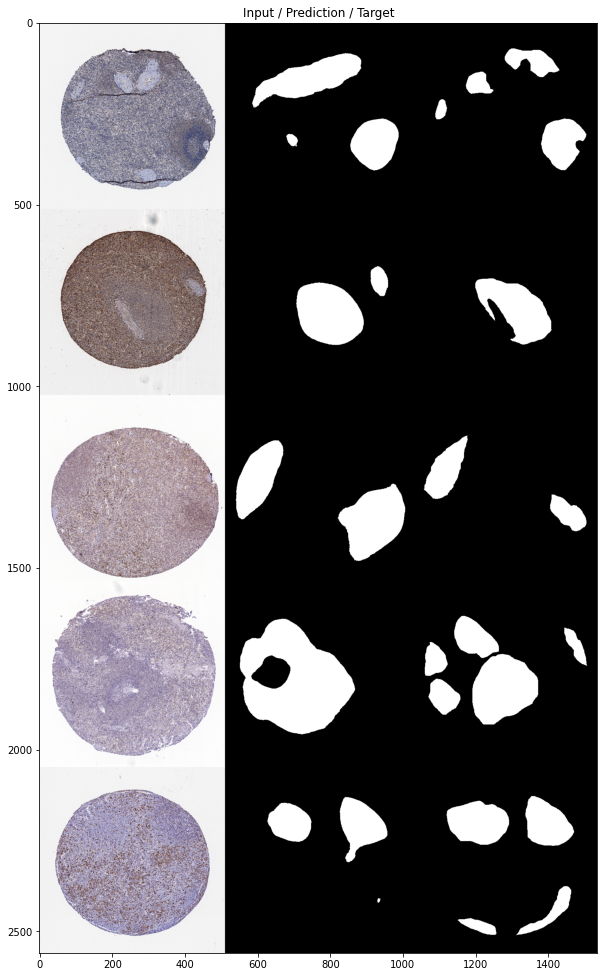

In [35]:
plot_results(model, test_dl, figsize=10, threshold=0.8)

In [ ]:
model = monai.networks.nets.SwinUNETR(
    IMAGE_SIZE[0], 
    3, 
    3, 
    spatial_dims=2,
    depths=(2, 2, 2, 2), 
    num_heads=(3, 6, 12, 24), 
    feature_size=24, 
    drop_rate=0.0, 
    attn_drop_rate=0.0, 
    dropout_path_rate=0.0
)
# remove this line:
model.load_state_dict(torch.load("../logs/15_denoising_pretraining/prostate_denoise/checkpoints/model.0005.pth"))
model.out.conv.conv = torch.nn.Conv2d(24, 2, kernel_size=(1, 1), stride=(1, 1))